In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tensorflow as tf
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')
import time

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
import xgboost as xgb
from tqdm import tqdm
import talib as ta
import functools  

### 1. Load, Clean, Create Features

In [ ]:
def load_data(supplement : bool) :
    stock_prices = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train_files/stock_prices.csv', parse_dates=True)
    secondary_stock_prices = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train_files/secondary_stock_prices.csv', parse_dates=True)
    options = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train_files/options.csv', parse_dates=True)
    financials = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train_files/financials.csv', parse_dates=True)
    stock_list = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/stock_list.csv')
    if supplement :
        supplemental_stock_prices = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/supplemental_files/stock_prices.csv', parse_dates=True)
        supplemental_secondary_stock_prices = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/supplemental_files/secondary_stock_prices.csv', parse_dates=True)
        supplemental_options = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/supplemental_files/options.csv', parse_dates=True)
        supplemental_financials = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/supplemental_files/financials.csv', parse_dates=True)
        
        stock_prices = stock_prices.append(supplemental_stock_prices)
        secondary_stock_prices = secondary_stock_prices.append(supplemental_secondary_stock_prices)
        options = options.append(supplemental_options)
        financials = financials.append(supplemental_financials)
    
    return stock_prices, secondary_stock_prices, options, financials, stock_list

def merge_stock_list(df : pd.DataFrame) :
    
    # On ajoute seulement la colonne 33 Sector Code qui donne le secteur de l'entreprise
    df = df.merge(stock_list[['SecuritiesCode','33SectorCode', '17SectorCode']], on='SecuritiesCode', how='left')
    df['33SectorCode'] = df['33SectorCode'].astype(int)
    df['17SectorCode'] = df['17SectorCode'].astype(int)
    return df

def merge_stock_list_secondary(df : pd.DataFrame) :
    # On ajoute seulement la colonne 33 Sector Code qui donne le secteur de l'entreprise
    df = df.merge(stock_list[['SecuritiesCode','33SectorCode', '17SectorCode']], on='SecuritiesCode', how='left')
    df = df.drop(df[df['33SectorCode']=='-'].index)
    df['33SectorCode'] = df['33SectorCode'].astype(int)
    df['17SectorCode'] = df['17SectorCode'].astype(int)
    return df

def preprocess_prices(df : pd.DataFrame) :
    
    # Cast the categorical data
    df['SecuritiesCode'] = df['SecuritiesCode'].astype('category')
    df['AdjustmentFactor'] = df['AdjustmentFactor'].astype('category')
    df['SupervisionFlag'] = df['SupervisionFlag'].map({True: 1, False: 0})
    
    # Remove useless column
    df.drop(columns = ['RowId'], axis=1, inplace=True)
    
    # Manage NaN values
    df['ExpectedDividend'] = df['ExpectedDividend'].fillna(0)
    df.dropna(inplace=True) # Il reste 8200 rows contenant que des Nan sur les colonnes OLHC, on les drop
    
    # Transform date into int
    df['Date'] = pd.to_datetime(df['Date'])
    df['DateInt'] = df['Date'].dt.strftime("%Y%m%d").astype(int)
    
    return df

def preprocess_prices_submission(df : pd.DataFrame) :
    
    # Cast the categorical data
    df['SecuritiesCode'] = df['SecuritiesCode'].astype('category')
    df['AdjustmentFactor'] = df['AdjustmentFactor'].astype('category')
    df['SupervisionFlag'] = df['SupervisionFlag'].map({True: 1, False: 0})
    
    # Remove useless column
    df.drop(columns = ['RowId'], axis=1, inplace=True)
    
    # Manage NaN values
    df['ExpectedDividend'] = df['ExpectedDividend'].fillna(0)
    
    # Transform date into int
    df['Date'] = pd.to_datetime(df['Date'])
    df['DateInt'] = df['Date'].dt.strftime("%Y%m%d").astype(int)
    
    return df

def fillna_prices_submission(df : pd.DataFrame) :
    df = df.sort_values(by=['SecuritiesCode']).fillna(method='backfill')
    return df

def add_secondary_market_features (df_prices : pd.DataFrame, df_secondary : pd.DataFrame) :
    df_prices = merge_stock_list(df_prices)
    df_secondary = merge_stock_list_secondary(df_secondary)
    df_all_securities = df_prices.append(df_secondary)
    date_sector_volume = df_all_securities.groupby(by=['Date','17SectorCode'])['Volume'].sum()
    date_sector_volume = date_sector_volume.reset_index()
    date_sector_volume = date_sector_volume.rename(columns = {'Volume' : 'VolumeSector'})
    del df_all_securities
    df_prices = df_prices.merge(date_sector_volume, on=['Date', '17SectorCode'], how='left')
    return df_prices

def add_options_features(df_prices : pd.DataFrame, df_options : pd.DataFrame) :
    df_options['Date'] = pd.to_datetime(df_options['Date'])
    put_call_day_volume = df_options.groupby(['Date','Putcall'])['TradingVolume'].sum().unstack().rename(columns={1:'Put',2:'Call'})
    put_call_day_volume['put/call'] = put_call_day_volume['Put']/put_call_day_volume['Call']
    put_call_day_volume['Volatility'] = df_options.groupby('Date')['ImpliedVolatility'].mean()
    df_prices = df_prices.merge(put_call_day_volume[['put/call', 'Volatility']], how='left', on='Date')
    return df_prices

def add_financials_features(df_prices, df_financials) :
  # preprocessing of financials
  df_financials = df_financials[['SecuritiesCode', 'DisclosedDate', 'Profit', 'EarningsPerShare', 'ForecastEarningsPerShare', 'ForecastProfit']]
  df_financials.dropna(inplace=True)
  df_financials['SecuritiesCode'] = df_financials['SecuritiesCode'].astype('int')
  df_financials['DisclosedDate'] = pd.to_datetime(df_financials['DisclosedDate'])
  df_financials.rename(columns={'DisclosedDate' : 'Date'}, inplace=True)
  df_financials.EarningsPerShare = pd.to_numeric(df_financials.EarningsPerShare, errors = 'coerce').fillna(0)
  df_financials.Profit = pd.to_numeric(df_financials.Profit, errors = 'coerce').fillna(0)
  df_financials.ForecastProfit = pd.to_numeric(df_financials.ForecastProfit, errors = 'coerce').fillna(0)
  df_financials.ForecastEarningsPerShare = pd.to_numeric(df_financials.ForecastEarningsPerShare, errors = 'coerce').fillna(0)   

  df_prices = df_prices.merge(df_financials, on=['SecuritiesCode', 'Date'], how='left')

  return df_prices

def add_cluster(df_prices) :
  df_cluster = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/clusters.csv')
  zip_iterator = zip(df_cluster.SecuritiesCode, df_cluster.Cluster)
  dict_cluster =dict(zip_iterator)
  df_prices['Cluster'] = df_prices['SecuritiesCode'].apply(lambda x : dict_cluster.get(x))

  return df_prices

In [ ]:
df_prices, df_secondary, df_options, df_financials, stock_list = load_data(1)

df_prices = preprocess_prices(df_prices)
df_secondary = preprocess_prices(df_secondary)

df_prices = add_secondary_market_features (df_prices, df_secondary)
df_prices = add_options_features(df_prices, df_options)
# df_prices = add_financials_features(df_prices, df_financials)
df_prices = add_cluster(df_prices)

In [ ]:
df_prices = add_financials_features(df_prices, df_financials)

In [ ]:
def get_talib_features(df):
    """
    Get technical features from TA-Lib
    """
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    vo = df['Volume']
    tar = df['Target']
    
    
    # Overlap Studies
    df['BBANDS_upper'], df['BBANDS_middle'], df['BBANDS_lower'] = ta.BBANDS(cl, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['EMA_20'] = ta.EMA(cl, timeperiod=20)
    df['HT_TRENDLINE'] = ta.HT_TRENDLINE(cl)
    df['TEMA_50'] = ta.TEMA(df['Close'], timeperiod=50)
    df['TEMA_30'] = ta.TEMA(df['Close'], timeperiod=30)
    df['TEMA_15'] = ta.TEMA(df['Close'], timeperiod=15)
    df['TEMA_10'] = ta.TEMA(df['Close'], timeperiod=10)
    df['EMA_Target_20'] = ta.TEMA(df['Target'], timeperiod=20)
    df['ROC'] = ta.ROC(cl, timeperiod=10)
    
    # Momentum Indicators
    df['ADX'] = ta.ADX(hi, lo, cl, timeperiod=14)
    df['ADXR'] = ta.ADXR(hi, lo, cl, timeperiod=14)
    df['APO'] = ta.APO(cl, fastperiod=12, slowperiod=26, matype=0)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = ta.MACD(cl, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MOM'] = ta.MOM(cl, timeperiod=10)
    df['RSI'] = ta.RSI(cl, timeperiod=14)
    
    # Volume Indicators
    df['AD'] = ta.AD(hi, lo, cl, vo)
    df['OBV'] = ta.OBV(cl, vo)
    
    # Volatility Indicators
    df['ATR'] = ta.ATR(hi, lo, cl, timeperiod=14)
    df['NATR'] = ta.NATR(hi, lo, cl, timeperiod=14)
    df['TRANGE'] = ta.TRANGE(hi, lo, cl) 
    
    return df

def add_features_security(df : pd.DataFrame, security : int):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        security (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    data_security = df[df.SecuritiesCode == security].copy()
    
    # Adds all 42 features
    data_security = get_talib_features(data_security)
    
    # filling data for nan and inf
    data_security = data_security.fillna(method='ffill')
    data_security = data_security.replace([np.inf, -np.inf, np.nan], 0)

    return data_security

def add_features_dataframe(df : pd.DataFrame) :
    codes = sorted(df["SecuritiesCode"].unique())
    buff = []
    for code in tqdm(codes):
        security_features = add_features_security(df, code)
        buff.append(security_features)
    df_augmented = pd.concat(buff)
    
    return df_augmented

In [ ]:
def drop_null_values_lagged(df) :
  codes = sorted(df["SecuritiesCode"].unique())
  buff = []
  for code in tqdm(codes):
    data_security = df[df.SecuritiesCode == code].copy()
    data_security.reset_index(drop=True, inplace=True)
    idx_drop = data_security[features_training].ne(0).idxmax().max()
    data_security.drop(data_security.iloc[:idx_drop].index, inplace=True)
    buff.append(data_security)
  df_clean = pd.concat(buff)
  
  return df_clean

In [ ]:
# trades = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train_files/trades.csv', parse_dates=True)
# supplemental_trades = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/supplemental_files/trades.csv', parse_dates=True)
# trades = trades.append(supplemental_trades)
# trades.dropna(inplace=True)
# trades.Date = pd.to_datetime(trades.Date)
# trades.TotalBalance = pd.to_numeric(trades.TotalBalance, errors = 'coerce').fillna(0)

# # df_prices = df_prices.merge(trades, on=['Date'], how='left')
# df_prices = df_prices.merge(trades, on=['Date'], how='left')
# df_prices.TotalBalance = df_prices.TotalBalance.fillna(0)

In [ ]:
df_prices = add_features_dataframe(df_prices)

100%|██████████| 2000/2000 [00:44<00:00, 44.47it/s]


In [ ]:
df_prices = drop_null_values_lagged(df_prices)

100%|██████████| 2000/2000 [00:22<00:00, 90.35it/s]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Defines the estimator used by the Boruta algorithm
estimator = RandomForestRegressor()

from boruta import BorutaPy
# Creates the BorutaPy object
boruta = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100)
# Fits Boruta
boruta.fit(np.array(df_prices[features_training]), np.array(df_prices.Target))

In [ ]:
lgbm_params = {'lambda': 0.020205134940549825,
               'alpha': 0.008714278321966324,
               'colsample_bytree': 1.0,
               'subsample': 0.8, #0.7
               'learning_rate': 0.0001, #0.001
               'n_estimators': 1600, #1000
               'num_leaves' : 64000,
               'max_depth': 16, #16
               'random_state': 2020,
               'min_data_in_leaf' : 1000,
               'min_child_weight': 258,
               'max_bin': 256,
               'grow_policy': 'lossguide'
               }

In [ ]:
test_params = {'alpha': 0.16257746173885726,
 'colsample_bytree': 1.0,
 'gamma': 0.0001,
 'min_data_in_leaf' : 1500,
 'grow_policy': 'depthwise',
 'lambda': 0.02205926877486453,
 'learning_rate': 0.001,
 'max_bin': 256,
 'max_depth': 20,
 'min_child_weight': 24,
 'missing': -999,
 'n_estimators': 1200,
 'subsample': 1.0}

In [ ]:
features = [# On garde date ici juste pour pouvoir faire classer les actions par Date, mais on l'enlève du training
    "SecuritiesCode",
    "17SectorCode",
    # OLHCV
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "AdjustmentFactor",
    "ExpectedDividend",
     # New
    #  "TotalBalance",
    # "Profit",
    # "ForecastProfit",
    "EarningsPerShare",
    "ForecastEarningsPerShare",
    "put/call",
    "VolumeSector",
    # Overlap Studies
    "BBANDS_upper",
    "BBANDS_lower",
    "EMA_20",
    "TEMA_15",
    "TEMA_30",
    "TEMA_50",
    "HT_TRENDLINE",
    "ROC",
    # Momentum Indicators
    "MACD_macd",
    "RSI",
    "APO",
    "ADX",
    # Volume Indicators
    "AD",
    "OBV",
    # Volatility Indicators
    "NATR",
    "Date",
    "Cluster",
    "Target"
]

In [ ]:
features_training = features.copy()
features_training.remove("Date")
# features_training.remove("Cluster")
features_training.remove("Target")
# features_training.remove("SecuritiesCode")

In [ ]:
df_prices.Cluster = df_prices.Cluster.astype('category')

In [ ]:
df_prices['17SectorCode'] = df_prices['17SectorCode'].astype('category')

In [ ]:
# Spliting train and test

TRAIN_END = "2022-03-31"
TEST_START = "2022-04-01"

df_train = df_prices[df_prices['Date'] <= TRAIN_END][features]
# df_train = drop_null_values_lagged(df_train)

df_test = df_prices[df_prices['Date'] >= TEST_START][features]

In [ ]:
def objective(trial, X_train=df_train[features_training], y_train=df_train.Target, X_val=df_test[features_training], y_val=df_test.Target):
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5,0.6,0.7,0.8,0.9,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.0001, 0.001, 0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'num_leaves' : trial.suggest_categorical('num_leaves', [512, 1024, 2048, 4092, 8000, 16000, 32000, 64000, 100000]),
        'n_estimators': trial.suggest_categorical('n_estimators', [ 700, 800, 1000, 1200, 1300]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,19]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', low=1, high=300),
        'max_bin': trial.suggest_categorical('max_bin', [128,256,512]),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'gamma': trial.suggest_categorical('gamma', [0, 1e-4, 1e-3]),
        'missing': trial.suggest_categorical('missing', [-999])
        # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        # 'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        # 'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7,0.8,0.9, 1.0]),
        # 'subsample': trial.suggest_categorical('subsample', [0.8,0.9,1.0]),
        # 'learning_rate': trial.suggest_categorical('learning_rate', [0.0001, 0.001,0.01,0.012,0.014,0.016,0.018, 0.02]),
        # 'n_estimators': trial.suggest_categorical('n_estimators', [ 700, 800, 1000, 1200, 1300]),
        # 'max_depth': trial.suggest_categorical('max_depth', [13,15,17,19,20]),
        # 'random_state': 2020,
        # 'min_child_weight': trial.suggest_int('min_child_weight', low=1, high=300),
        # 'max_bin': trial.suggest_categorical('max_bin', [128,256,512]),
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        # 'gamma': trial.suggest_categorical('gamma', [0, 1e-4, 1e-3]),
        # 'missing': trial.suggest_categorical('missing', [-999])
    }

    model = LGBMRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],early_stopping_rounds=100, verbose=False)
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds,squared=False)

    return rmse

In [ ]:
pip install optuna

In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_trial = study.best_trial.params

[I 2022-07-03 17:27:39,559] A new study created in memory with name: no-name-3f6e4a8f-6572-426e-adb6-8e5a1c210391
[I 2022-07-03 17:33:46,012] Trial 0 finished with value: 0.024450839866321513 and parameters: {'lambda': 0.21237155538728297, 'alpha': 0.0012690928890218105, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.018, 'num_leaves': 32000, 'n_estimators': 700, 'max_depth': 19, 'random_state': 2020, 'min_child_weight': 27, 'max_bin': 256, 'grow_policy': 'depthwise', 'gamma': 0.0001, 'missing': -999}. Best is trial 0 with value: 0.024450839866321513.
[I 2022-07-03 17:34:24,454] Trial 1 finished with value: 0.02444775995343584 and parameters: {'lambda': 9.103338762041776, 'alpha': 0.008269309871904381, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.012, 'num_leaves': 64000, 'n_estimators': 800, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 269, 'max_bin': 128, 'grow_policy': 'depthwise', 'gamma': 0.001, 'missing': -999}. Best is trial 1 with va

In [ ]:
best_trial

{'alpha': 0.16257746173885726,
 'colsample_bytree': 1.0,
 'gamma': 0.0001,
 'grow_policy': 'depthwise',
 'lambda': 0.02205926877486453,
 'learning_rate': 0.02,
 'max_bin': 256,
 'max_depth': 20,
 'min_child_weight': 24,
 'missing': -999,
 'n_estimators': 1200,
 'subsample': 1.0}

In [ ]:
df_train['Cluster'] = df_train['Cluster'].astype('category')
df_test['Cluster'] = df_test['Cluster'].astype('category')

In [ ]:
params_best = {'lambda': 0.05661463119631258, 'alpha': 0.12576633678332605, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'num_leaves': 8000, 'n_estimators': 1300, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 170, 'max_bin': 128, 'grow_policy': 'depthwise', 'gamma': 0, 'missing': -999}


In [ ]:
pred_model = LGBMRegressor(**lgbm_params)
pred_model.fit(df_train[features_training], df_train.Target)

In [ ]:
clusters = sorted(df_prices['Cluster'].unique())

In [ ]:
for cluster in tqdm(clusters) :
  string_model = "model_{}".format(cluster)
  model = LGBMRegressor(**lgbm_params)
  df = df_train[df_train['Cluster']==cluster]
  model.fit(df[features_training], df.Target)
  globals()[string_model] = model

100%|██████████| 6/6 [04:48<00:00, 48.13s/it]


In [ ]:
def set_rank_date(df):
    """
    Args:
        df (pd.DataFrame): df including predict_column for a Date
    Returns:
        df (pd.DataFrame): df with Rank for a day
    """ 
    # sort records to set Rank
    df = df.sort_values("TargetPredicted", ascending=False)
    # set Rank starting from 0
    df["Rank"] = np.arange(len(df["TargetPredicted"]))
    return df
  
def set_rank(df) :
    # df_test
    buff = []
    for cluster in tqdm(clusters) :
      string_model = "model_{}".format(cluster)
      model = globals()[string_model]
      df_code = df[df['Cluster']==cluster]
      df_code['TargetPredicted'] = model.predict(df_code[features_training])
      buff.append(df_code)
    predictions = pd.concat(buff)
    predictions = predictions.sort_values(["Date", "TargetPredicted"], ascending=[True, False])
    predictions = predictions.groupby("Date").apply(set_rank_date)
    predictions = predictions.reset_index(drop=True)
    return predictions

def set_rank_full(df) :
        
    df['TargetPredicted'] = pred_model.predict(df[features_training])
    df = df.sort_values(["Date", "TargetPredicted"], ascending=[True, False])
    df = df.groupby("Date").apply(set_rank_date)
    df = df.reset_index(drop=True)
    return df

In [ ]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [ ]:
def calc_spread_average_return(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean()
    return sharpe_ratio

In [ ]:
predicted_rank = set_rank_full(df_test)

In [ ]:
predicted_rank = set_rank(df_test)

100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


In [ ]:
calc_spread_return_sharpe(predicted_rank)

0.19802143656238458

In [ ]:
calc_spread_average_return(predicted_rank)

0.3865490071469996

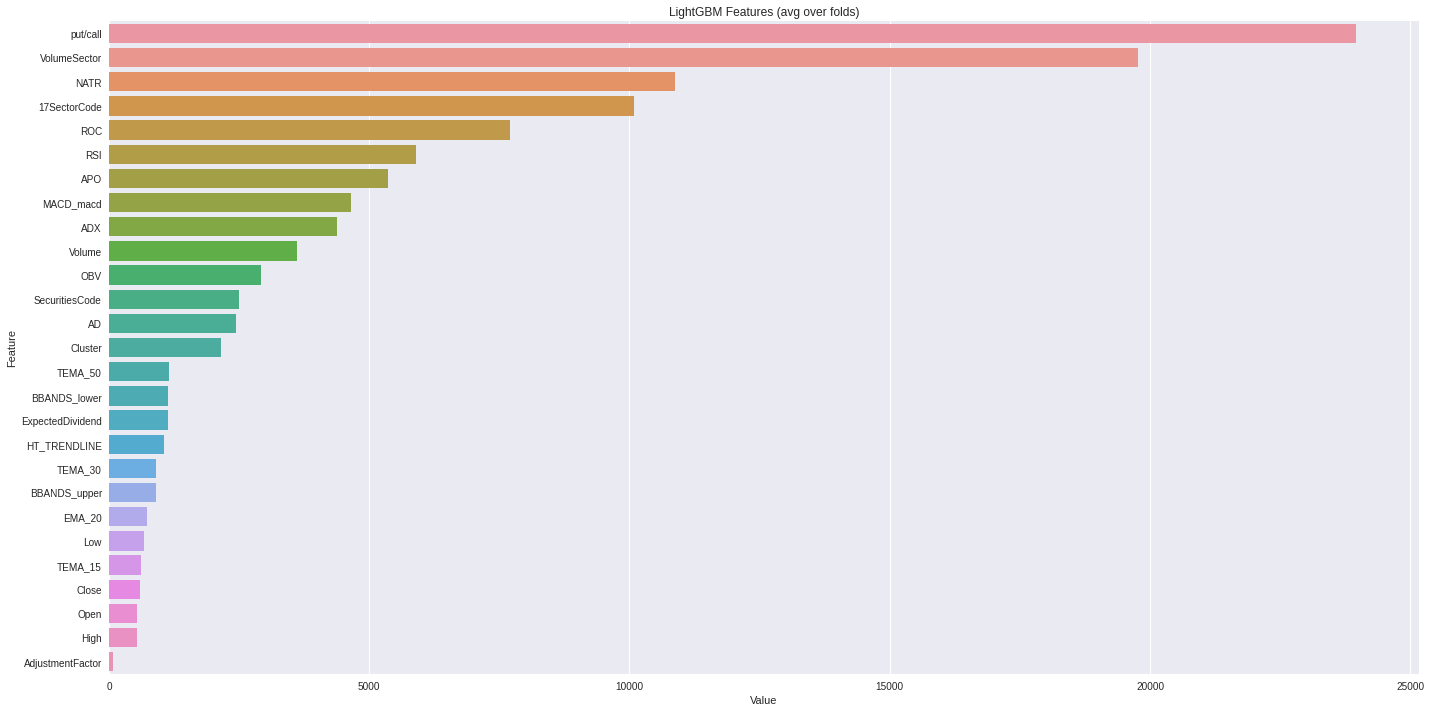

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(pred_model.feature_importances_,df_train[features_training].columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
df_prices[features_nodate_nocode].corr()

,Open,High,Low,Close,Volume,ExpectedDividend,put/call,VolumeSector,BBANDS_upper,BBANDS_lower,...,TEMA_30,TEMA_50,HT_TRENDLINE,MACD_macd,RSI,APO,ADX,AD,OBV,NATR
Open,1.000000,0.999855,0.999855,0.999733,-0.034631,0.043230,-0.004279,0.023052,0.996100,0.996639,...,0.965609,0.940039,0.970691,0.141748,0.061015,0.100586,0.017072,0.070599,0.030356,-0.015065
High,0.999855,1.000000,0.999764,0.999860,-0.034401,0.043107,-0.004216,0.024042,0.996225,0.996312,...,0.965416,0.939837,0.970473,0.142369,0.062441,0.100811,0.018095,0.070648,0.030520,-0.011608
Low,0.999855,0.999764,1.000000,0.999866,-0.034772,0.043338,-0.004557,0.021980,0.995851,0.996824,...,0.965637,0.939980,0.970688,0.141987,0.062576,0.100696,0.016192,0.070566,0.030234,-0.019118
Close,0.999733,0.999860,0.999866,1.000000,-0.034579,0.043297,-0.004541,0.022970,0.995979,0.996505,...,0.965480,0.939853,0.970495,0.142634,0.064130,0.100921,0.017178,0.070651,0.030388,-0.015689
Volume,-0.034631,-0.034401,-0.034772,-0.034579,1.000000,-0.000245,-0.006686,0.090722,-0.033994,-0.035437,...,-0.033155,-0.031817,-0.033622,-0.002611,-0.000572,-0.001954,0.013691,-0.404730,-0.115906,0.022728
ExpectedDividend,0.043230,0.043107,0.043338,0.043297,-0.000245,1.000000,-0.007964,-0.004971,0.043112,0.043210,...,0.040520,0.041437,0.039847,0.006476,0.010474,0.004819,0.006094,0.004182,0.001527,-0.006270
put/call,-0.004279,-0.004216,-0.004557,-0.004541,-0.006686,-0.007964,1.000000,-0.023104,-0.001822,-0.002427,...,0.022322,0.021950,0.018935,-0.026017,-0.044631,-0.014187,0.007523,-0.001910,0.000074,0.071606
VolumeSector,0.023052,0.024042,0.021980,0.022970,0.090722,-0.004971,-0.023104,1.000000,0.024686,0.019419,...,0.009397,0.000802,0.013326,-0.000321,-0.016854,-0.001182,0.030501,-0.034779,0.011495,0.143518
BBANDS_upper,0.996100,0.996225,0.995851,0.995979,-0.033994,0.043112,-0.001822,0.024686,1.000000,0.995232,...,0.966562,0.941400,0.972319,0.133481,0.059806,0.097134,0.024856,0.070532,0.030812,0.010114
BBANDS_lower,0.996639,0.996312,0.996824,0.996505,-0.035437,0.043210,-0.002427,0.019419,0.995232,1.000000,...,0.967156,0.941537,0.972540,0.136941,0.061726,0.098918,0.017403,0.070446,0.029972,-0.025044
